## Задача 1

Реализовать класс для работы с линейной регрессией

In [1]:
import pandas as pd
import numpy as np

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регуляризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регуляризации l2 не задано")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size



    def fit(self, X: pd.DataFrame, y: pd.DataFrame, stopping_criteria=0.0001, learning_rate=0.001, max_iter=15000):

        X_new = np.concatenate((np.array(np.ones(len(X)))[:, None], X), axis=1)

        # Точное решение(Готово!)
        if self.weight_calc == 'matrix':

            W = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y
            
        
        # Градиентный спуск(Готово!)
        elif self.weight_calc == 'gd':
            
            np.random.seed(seed=10)
            W = np.random.uniform(size=(X_new.shape[1]))
            grad = (2/X_new.shape[0]) * X_new.T @ (X_new @ W - y)
            num_iter = 0

            while np.linalg.norm(grad) > stopping_criteria and num_iter < max_iter:
                if self.regularization == None:
                    W -= learning_rate * grad 
                elif self.regularization == 'l1':
                    W -= learning_rate * ( grad + self.lambda_1 * np.sign(W) )
                elif self.regularization == 'l2':
                    W -= learning_rate * ( grad + self.lambda_2 * W )
                else:
                    W -= learning_rate * ( grad + self.lambda_2 * W + self.lambda_1 * np.sign(W) )
                
                grad = (2/X_new.shape[0]) * X_new.T @ (X_new @ W - y)
                num_iter += 1

            

        # Стохастический градиентный спуск(Готово!)
        else: 
            idx = np.random.randint(X.shape[0], size=self.batch_size)
            X_st = X_new[idx, :]
            y_st = y[idx]

            np.random.seed(seed=10)
            W = np.random.uniform(size=(X_st.shape[1]))
            grad = (2/X_st.shape[0]) * X_st.T @ (X_st @ W - y_st)
            num_iter = 0

            while np.linalg.norm(grad) > stopping_criteria and num_iter < max_iter:
                if self.regularization == None:
                    W -= learning_rate * grad 
                elif self.regularization == 'l1':
                    W -= learning_rate * grad + self.lambda_1 * np.sign(W)
                elif self.regularization == 'l2':
                    W -= learning_rate * grad + self.lambda_2 * W
                else:
                    W -= learning_rate * grad + self.lambda_2 * W + self.lambda_1 * np.sign(W)
                
                grad = (2/X_st.shape[0]) * X_st.T @ (X_st @ W - y_st)
                num_iter += 1


        self.weights = W
        self.interpect_ = W[0]
        self.coefs_ = W[1:]

    # Готово!
    def predict(self, X: np.array, ss=True):
        X_new = np.concatenate((np.array(np.ones(len(X)))[:, None], X), axis=1)
        
        return X_new @ self.weights

    # Готово!
    def score(self, X: np.array, y: np.array):
        
        return np.linalg.norm(X - y) * (1/len(y))

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

### Проверим как работает

датасет про автомобили не загрузился, поэтому взял про диабет

In [2]:
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

diabetes = datasets.load_diabetes()

In [3]:
# Разбиваем на обучение и тест
X = diabetes['data']
y = diabetes['target']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

Text(0.5, 1.0, 'MSE в зависимости от параметра регуляризации')

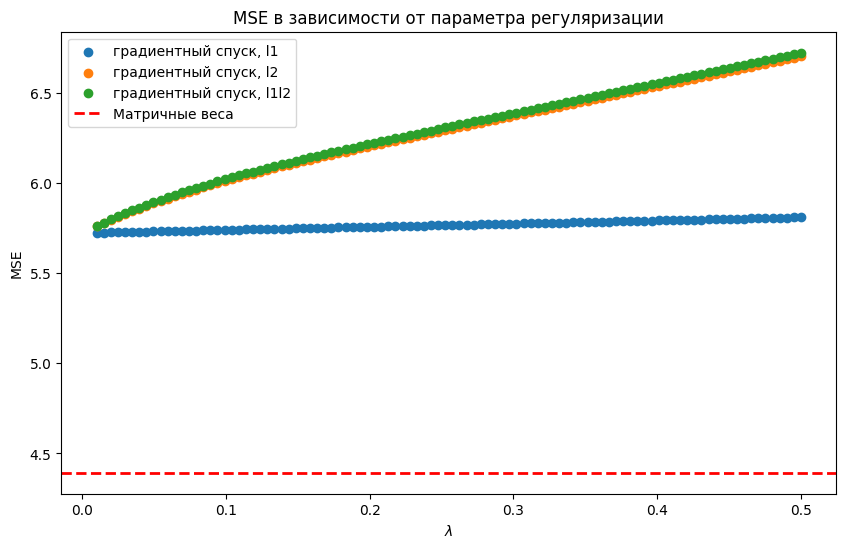

In [4]:
x_range = np.linspace(0.01, 0.5, 100)
y_scores_l1 = []
y_scores_l2 = []
y_scores_l1l2 = []


for lambd in x_range:
    # l1 
    model_gd = MyLinearRegression(weight_calc='gd', regularization='l1', lambda_1 = lambd)
    model_gd.fit(X_train, y_train)
    y_pr_l1 = model_gd.predict(X_test)
    y_scores_l1.append(model_gd.score(y_pr_l1, y_test))

    # l2
    my_model = MyLinearRegression(weight_calc='gd', regularization='l2', lambda_2 = lambd)
    my_model.fit(X_train, y_train)
    y_pr_l2 = my_model.predict(X_test)
    y_scores_l2.append(my_model.score(y_pr_l2, y_test))

    # l1l2
    my_model = MyLinearRegression(weight_calc='gd', regularization='l1l2', lambda_1 = lambd, lambda_2 = lambd)
    my_model.fit(X_train, y_train)
    y_pr_l1l2 = my_model.predict(X_test)
    y_scores_l1l2.append(my_model.score(y_pr_l1l2, y_test))


# Веса с помощью матрицы
model_mx = MyLinearRegression(weight_calc='matrix')
model_mx.fit(X_train, y_train)
y_pr_mx = model_mx.predict(X_test)
y_mx = model_mx.score(y_pr_mx, y_test)

plt.figure(figsize=(10,6))
plt.scatter(x_range, y_scores_l1, label='градиентный спуск, l1')
plt.scatter(x_range, y_scores_l2, label='градиентный спуск, l2')
plt.scatter(x_range, y_scores_l1l2, label='градиентный спуск, l1l2')
plt.axhline(y=y_mx, color='red', linestyle='--', linewidth=2, label='Матричные веса')
plt.xlabel(f'$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.title(f'MSE в зависимости от параметра регуляризации')

Text(0.5, 1.0, 'MSE в зависимости от параметра регуляризации')

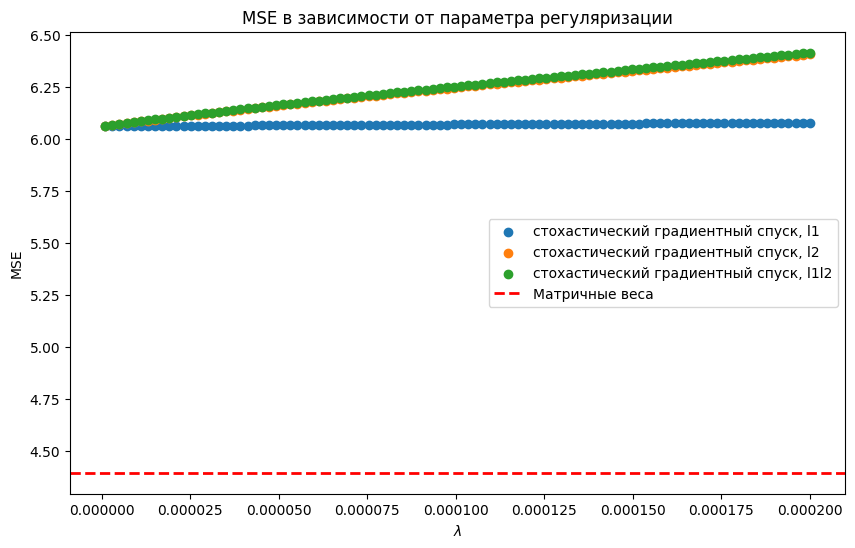

In [5]:
x_range = np.linspace(0.000001, 0.0002, 100)
y_scores_l1 = []
y_scores_l2 = []
y_scores_l1l2 = []


for lambd in x_range:
    # l1 
    model_gd = MyLinearRegression(weight_calc='sgd', regularization='l1', lambda_1 = lambd)
    model_gd.fit(X_train, y_train)
    y_pr_l1 = model_gd.predict(X_test)
    y_scores_l1.append(model_gd.score(y_pr_l1, y_test))

    # l2
    my_model = MyLinearRegression(weight_calc='sgd', regularization='l2', lambda_2 = lambd)
    my_model.fit(X_train, y_train)
    y_pr_l2 = my_model.predict(X_test)
    y_scores_l2.append(my_model.score(y_pr_l2, y_test))

    # l1l2
    my_model = MyLinearRegression(weight_calc='sgd', regularization='l1l2', lambda_1 = lambd, lambda_2 = lambd)
    my_model.fit(X_train, y_train)
    y_pr_l1l2 = my_model.predict(X_test)
    y_scores_l1l2.append(my_model.score(y_pr_l1l2, y_test))


# Веса с помощью матрицы
model_mx = MyLinearRegression(weight_calc='matrix')
model_mx.fit(X_train, y_train)
y_pr_mx = model_mx.predict(X_test)
y_mx = model_mx.score(y_pr_mx, y_test)

plt.figure(figsize=(10,6))
plt.scatter(x_range, y_scores_l1, label='стохастический градиентный спуск, l1')
plt.scatter(x_range, y_scores_l2, label='стохастический градиентный спуск, l2')
plt.scatter(x_range, y_scores_l1l2, label='стохастический градиентный спуск, l1l2')
plt.axhline(y=y_mx, color='red', linestyle='--', linewidth=2, label='Матричные веса')
plt.xlabel(f'$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.title(f'MSE в зависимости от параметра регуляризации')

Для sgd значение лямбда делаем сильно меньше чем для gd, поскольку иначе он будет сильно "скакать" и никуда не сойдётся -> получим высокий MSE

#### Сравним модель с sklearn реализацией

In [24]:
# -- собственные модели --
my_model_ridge = MyLinearRegression(regularization='l2', weight_calc='gd', lambda_2 = 0.5)
my_model_lasso = MyLinearRegression(regularization='l1', weight_calc='gd', lambda_1 = 0.5)
my_model_elast = MyLinearRegression(regularization='l1l2', weight_calc='gd', lambda_1 = 1, lambda_2 = 0.5)
 

fit_start_time_ridge = time.time()
my_model_ridge.fit(X_train, y_train)
fit_end_time_ridge = time.time()
y_pred_ridge = my_model_ridge.predict(X_test)
pred_end_time_ridge = time.time()


fit_start_time_lasso = time.time()
my_model_lasso.fit(X_train, y_train)
fit_end_time_lasso = time.time()
y_pred_lasso = my_model_lasso.predict(X_test)
pred_end_time_lasso = time.time()


fit_start_time_elast = time.time()
my_model_elast.fit(X_train, y_train)
fit_end_time_elast = time.time()
y_pred_elast = my_model_elast.predict(X_test)
pred_end_time_elast = time.time()


comparison = pd.DataFrame({'model': 'ridge_my', 'MSE': [round(my_model_ridge.score(y_test, y_pred_ridge), 4)], "fit_time": [round(fit_end_time_ridge - fit_start_time_ridge, 4)], 'predict_time': [round(pred_end_time_ridge - fit_end_time_ridge, 4)]})
comparison = pd.concat([comparison, pd.DataFrame({'model': 'lasso_my', 'MSE': [round(my_model_ridge.score(y_test, y_pred_lasso), 4)], "fit_time": [round(fit_end_time_lasso - fit_start_time_lasso, 4)], 'predict_time': [round(pred_end_time_lasso - fit_end_time_lasso, 4)]})])
comparison = pd.concat([comparison, pd.DataFrame({'model': 'elasticnet_my', 'MSE': [round(my_model_ridge.score(y_test, y_pred_elast), 4)], "fit_time": [round(fit_end_time_elast - fit_start_time_elast, 4)], 'predict_time': [round(pred_end_time_elast - fit_end_time_elast, 4)]})])



# -- sklearn модели --
ridge = Ridge()
lasso = Lasso()
elast = ElasticNet()


fit_start_time_ridge = time.time()
ridge.fit(X_train, y_train)
fit_end_time_ridge = time.time()
y_ridge = ridge.predict(X_test)
pred_end_time_ridge = time.time()


fit_start_time_lasso = time.time()
lasso.fit(X_train, y_train)
fit_end_time_lasso = time.time()
y_lasso = lasso.predict(X_test)
pred_end_time_lasso = time.time()


fit_start_time_elast = time.time()
elast.fit(X_train, y_train)
fit_end_time_elast = time.time()
y_elast = elast.predict(X_test)
pred_end_time_elast = time.time()


comparison = pd.concat([comparison, pd.DataFrame({'model': 'ridge_sklearn', 'MSE': [round(my_model_ridge.score(y_test, y_ridge), 4)], "fit_time": [round(fit_end_time_ridge - fit_start_time_ridge, 4)], 'predict_time': [round(pred_end_time_ridge - fit_end_time_ridge, 4)]})])
comparison = pd.concat([comparison, pd.DataFrame({'model': 'lasso_sklearn', 'MSE': [round(my_model_ridge.score(y_test, y_lasso), 4)], "fit_time": [round(fit_end_time_lasso - fit_start_time_lasso, 4)], 'predict_time': [round(pred_end_time_lasso - fit_end_time_lasso, 4)]})])
comparison = pd.concat([comparison, pd.DataFrame({'model': 'elasticnet_sklearn', 'MSE': [round(my_model_ridge.score(y_test, y_elast), 4)], "fit_time": [round(fit_end_time_elast - fit_start_time_elast, 4)], 'predict_time': [round(pred_end_time_elast - fit_end_time_elast, 4)]})])

In [25]:
comparison.sort_values(by='model', ascending=False)

,model,MSE,fit_time,predict_time
0,ridge_sklearn,4.6794,0.0005,0.0001
0,ridge_my,6.7021,0.1239,0.0000
0,lasso_sklearn,5.0131,0.0003,0.0001
0,lasso_my,5.8086,0.1153,0.0000
0,elasticnet_sklearn,6.2501,0.0002,0.0000
0,elasticnet_my,6.7397,0.1290,0.0000


In [26]:
import plotly.express as px
px.bar(comparison.sort_values(by='model'), x='model', y='MSE', title='MSE: сравнение моделей sklearn и собственных')

Качество у модели из sklearn лучше при любом типе регуляризации

In [27]:
import plotly.express as px
px.bar(comparison.sort_values(by='model'), x='model', y='fit_time', title='fit_time: сравнение моделей sklearn и собственных')

Время обучения модели из sklearn на 2-3 порядка меньше!!!

In [28]:
import plotly.express as px
px.bar(comparison.sort_values(by='model'), x='model', y='predict_time', title='predict_time: сравнение моделей sklearn и собственных')

### Сравнение весов:

In [ ]:
import pandas as pd

weights_df_ridge = pd.DataFrame(data={
        'model': ['ridge_my']*10 + ['ridge_sklearn']*10,
        'weight_number': [f'w{j}' for j in range(10)]*2,
        'weight_value': list(map(round, my_model_ridge.coefs_)) + list(map(round, ridge.coef_))
        })

px.bar(weights_df_ridge,
        x='model',
        y='weight_value', 
        color='weight_number', 
        barmode='group',
        title='Значения весов моделей для l2 регуляризации')

У модели из sklearn сильно больше абсолютные значения весов

In [30]:
import pandas as pd

weights_df_lasso = pd.DataFrame(data={
        'model': ['lasso_my']*10 + ['lasso_sklearn']*10,
        'weight_number': [f'w{j}' for j in range(10)]*2,
        'weight_value': list(map(round, my_model_lasso.coefs_)) + list(map(round, lasso.coef_))
        })

px.bar(weights_df_lasso,
        x='model',
        y='weight_value', 
        color='weight_number', 
        barmode='group',
        title='Значения весов моделей для l1 регуляризации')

- Модель из sklearn, как и должно быть, зануляет некоторые коэффициенты, но те что не равны нулю, большие по модулю 
- При этом собственная модель зануляет намного меньше коэффициентов, но и не позволяет весам так сильно расти

In [31]:
import pandas as pd

weights_df_elast = pd.DataFrame(data={
        'model': ['elasticnet_my']*10 + ['elasticnet_sklearn']*10,
        'weight_number': [f'w{j}' for j in range(10)]*2,
        'weight_value': list(map(round, my_model_elast.coefs_)) + list(map(round, elast.coef_))
        })

px.bar(weights_df_elast,
        x='model',
        y='weight_value', 
        color='weight_number', 
        barmode='group',
        title='Значения весов моделей для l1 + l2 регуляризации')

ElasticNet из sklearn прямо из коробки не даёт весам сильно расти

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)